## Exercise 6

In [39]:
import numpy as np

def Modeldefs(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Y: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    ell = Y
    z = Z
    
    # find definintion values
    Y = k**alpha*(np.exp(z)*ell)**(1-alpha)
    w = (1-alpha)*(k**alpha)*(np.exp(z))*(ell*np.exp(z))**(-alpha)
    r = alpha*k**(alpha-1)*(ell*np.exp(z))**(1-alpha)
    T = tau*(w*ell + (r-delta)*k)
    c = (1 - tau) * (w * ell + (r - delta) * k) + T + k - kp
    u = (c**(1-gamma)-1)/(1-gamma) + a*((1-ell)**(1-xi)-1)/(1-xi)
    i = delta*k
    return Y, w, r, c, u, T, i

In [40]:
def Modeldyn(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theta0
    (Xpp, Ypp, Xp, Yp, X, Y, Zp, Z) = theta0
    ell = Yp

    # find definitions for now and next period
    Y, w, r, c, u, T, i = Modeldefs(Xp, X,Yp, Z, params)
    Yp, wp, rp, cp, up, Tp, ip = Modeldefs(Xpp, Xp, Ypp, Zp, params)
    
    # Evaluate Euler equations
    E2 = beta*(c/cp)**(gamma)*((rp-delta)*(1-tau)+1)-1
    E1 = a*((c**(gamma))/(1-ell)**xi)*(1/(w*(1-tau)))-1
 
    return np.array([E1, E2])

In [41]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.optimize as opt
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

In [42]:
# set parameter values
gamma = 2.5
xi = 1.5
beta = .98
alpha =.40
a = .50
delta = .10
rho = .90
tau = .05

# make parameter list to pass to functions
params = (gamma, xi, beta, alpha, a, delta, rho, tau)

# set LinApp parameters
Zbar = np.array([0.])
nx = 2
ny = 0
nz = 1
logX = 1
Sylv = 1

In [43]:
# take a guess for steady state values of k and ell
guessXY = np.array([2.0, 0.5])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar
print ('XYbar: ', XYbar)

# set up steady state input vector
theta0 = np.array([kbar, ellbar, kbar, ellbar, kbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')

XYbar:  [ 4.22522903  0.57979145]
check:  [  9.72533165e-12  -3.93751698e-12]


In [44]:
Ybar, wbar, rbar, cbar, ubar, Tbar, ibar = Modeldefs(kbar, kbar, ellbar, 0, params)
print ('Ybar: ', Ybar)
print ('wbar: ', wbar)
print ('rbar: ', rbar)
print ('cbar: ', cbar)
print ('ubar: ', ubar)
print ('Tbar: ', Tbar)
print ('ibar: ', ibar)

Ybar:  1.28322610887
wbar:  1.32795276838
rbar:  0.121482277117
cbar:  0.860703206163
ubar:  -0.710872638109
Tbar:  0.0430351603081
ibar:  0.422522902705


In [45]:
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, WW, TT] = \
    LinApp_Deriv(Modeldyn, params, theta0, nx, ny, nz, logX)
print('FF: ', FF)
print('GG: ', GG)
print('HH: ', HH)
print('LL: ', LL)
print('MM: ', MM)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

FF:  [[  0.           0.        ]
 [ 12.27260744  -2.16849645]]
GG:  [[-12.27260744   4.70601255]
 [-24.87671844   2.23635645]]
HH:  [[ 12.13625099   0.        ]
 [ 12.53625099   0.        ]]
LL:  [[ 0.        ]
 [-2.16849645]]
MM:  [[ 1.63635645]
 [ 2.23635645]]
Sylvester equation solver condition is not satisfied; proceed with the original method...
Using Sylvester equation solver...


/Users/Geoff/anaconda/lib/python3.5/site-packages/scipy/linalg/decomp.py:60: RuntimeWarning: divide by zero encountered in true_divide
  w = (alphar + _I * alphai) / beta
/Users/Geoff/anaconda/lib/python3.5/site-packages/scipy/linalg/decomp.py:60: RuntimeWarning: invalid value encountered in true_divide
  w = (alphar + _I * alphai) / beta


LinAlgError: singular matrix

I can't figure out what's going wrong here! I'm getting some negative entries in the F-N matrices.

## Problem 7

In [66]:
F = np.array([[  0.        ,   0.        ],[ 12.27260744,  -2.16849645]])
G = np.array([[  12.27260744        ,   -4.70601255        ],[ -24.87671844,  2.23635645]])
H = np.array([[-12.13625099,   0.        ],[ 12.53625099,   0.        ]])
L = np.array([[ 0.        ], [-2.16849645]])
M = np.array([[-1.63635645], [ 2.23635645]])

P = np.array([[ 0.91529369,  0.        ], [-0.19192699,  0. ]])
P0 = P[0,0]
P1 = P[1,0]

Q = np.array([[ 0.12899709], [-0.01131016]])
Q0 = Q[0,0]
Q1 = Q[1,0]

# set parameter values
gamma = 2.5
xi = 1.5
beta = .98
alpha =.40
a = .50
delta = .10
rho = .90
tau = .05
sigma = 0.02
 

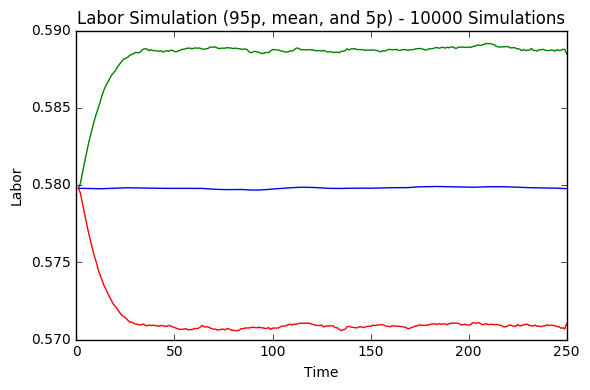

In [112]:
import matplotlib.pyplot as plt

#Generation random error terms and then calculate the z values
eps = np.random.normal(0, scale=sigma, size=(10000, 250))
z = np.zeros_like(eps)
z[:,0] = np.zeros(10000)
for i in range(1,10001):
    z[i-1,0] = 0
    for j in range(1, 250):
        z[i-1,j-1] = rho*z[i-1, j-2] + eps[i-1,j-1]
    
#Create the k matrix
k = np.zeros_like(eps)
for i in range(1, 250):
    k[:,i] = P0*k[:,i-1] + Q0*z[:,i]

#Create the ell matrix
ell = np.zeros_like(eps)
for i in range(1, 250):
    ell[:,i] = P1*k[:,i-1] + Q1*z[:,i]
    
k = (kbar*np.exp(k))
ell = (ellbar*np.exp(ell))

#Graph the labor simulation in each period
ellmean = ell.mean(axis=0)
ell95 = np.percentile(ell, 95, axis = 0)
ell5 = np.percentile(ell, 5, axis = 0)

x = np.linspace(1,250,250)
plt.plot(x, ellmean)
plt.plot(x, ell95)
plt.plot(x, ell5)
plt.title("Labor Simulation (95p, mean, and 5p) - 10000 Simulations")
plt.xlabel("Time")
plt.ylabel("Labor")
plt.tight_layout()
plt.show()

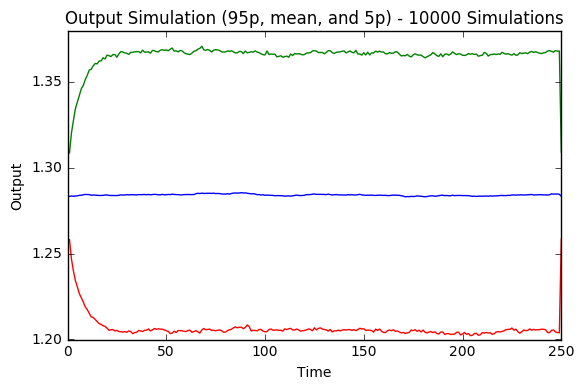

In [113]:
#Graph the GDP simulation in each period

y = np.zeros_like(eps)
for i in range(10000):
    for j in range(250):
        y[i,j] = k[i,j]**alpha*(np.exp(z[i,j])*ell[i,j])**(1-alpha)
        
ymean = y.mean(axis=0)
y95 = np.percentile(y, 95, axis = 0)
y5 = np.percentile(y, 5, axis = 0)
        
x = np.linspace(1,250,250)
plt.plot(x, ymean)
plt.plot(x, y95)
plt.plot(x, y5)
plt.title("Output Simulation (95p, mean, and 5p) - 10000 Simulations")
plt.xlabel("Time")
plt.ylabel("Output")
plt.tight_layout()
plt.show()

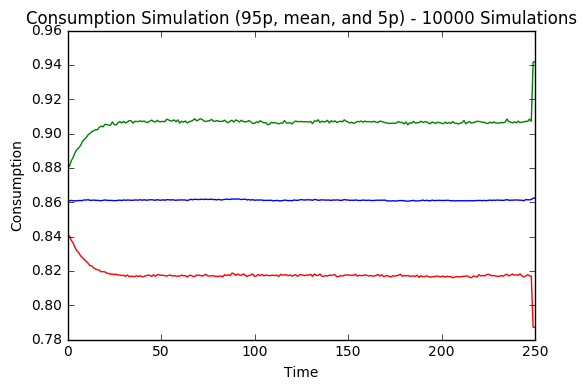

In [130]:
#Graph the consumption simulation in each period

w = np.zeros_like(eps)
r = np.zeros_like(eps)
T = np.zeros_like(eps)
for i in range(10000):
    for j in range(250):
        w[i,j] = (1-alpha)*(k[i,j]**alpha)*(np.exp(z[i,j]))*(ell[i,j]*np.exp(z[i,j]))**(-alpha)
        r[i,j] = alpha*k[i,j]**(alpha-1)*(ell[i,j]*np.exp(z[i,j]))**(1-alpha)
        T[i,j] = tau*(w[i,j]*ell[i,j] + (r[i,j]-delta)*k[i,j])

c = np.zeros_like(eps)
for i in range(10000):
    for j in range(249):
        c[i,j] = (1 - tau) * (w[i,j] * ell[i,j] + (r[i,j] - delta) * k[i,j]) + T[i,j] + k[i,j] - k[i,j+1]
    c[i,249] = c[i,248]
        
cmean = c.mean(axis=0)
c95 = np.percentile(c, 95, axis = 0)
c5 = np.percentile(c, 5, axis = 0)
        
x = np.linspace(1,250,250)
plt.plot(x, cmean)
plt.plot(x, c95)
plt.plot(x, c5)
plt.title("Consumption Simulation (95p, mean, and 5p) - 10000 Simulations")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.tight_layout()
plt.show()

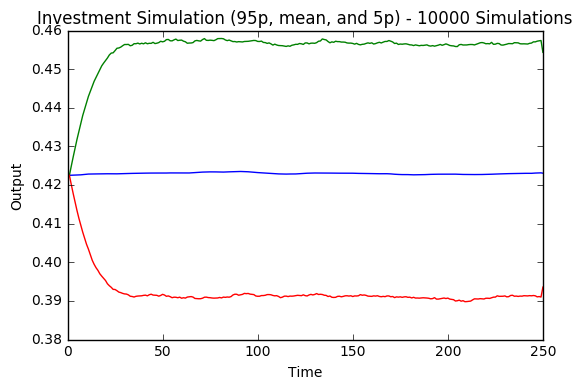

In [131]:
#Graph the investment simulation in each period

I = np.zeros_like(eps)
for i in range(10000):
    for j in range(250):
        I[i,j] = delta*k[i,j]
        
Imean = I.mean(axis=0)
I95 = np.percentile(I, 95, axis = 0)
I5 = np.percentile(I, 5, axis = 0)
        
x = np.linspace(1,250,250)
plt.plot(x, Imean)
plt.plot(x, I95)
plt.plot(x, I5)
plt.title("Investment Simulation (95p, mean, and 5p) - 10000 Simulations")
plt.xlabel("Time")
plt.ylabel("Output")
plt.tight_layout()
plt.show()

## Exercise 8

In [145]:
#Moments for labor 

ellmean = ell.mean(axis=1)
ellmeanavg = ellmean.mean()
ellmeanstd = ellmean.std()
print("Labor mean: " +str(ellmeanavg))
print("Std error on labor mean: " + str(ellmeanstd))
print("")

ellvol = ell.std(axis=1)
ellvolavg = ellvol.mean()
ellvolstd = ellvol.std()
print("Labor volatility: " +str(ellvolavg))
print("Std error on labor volatility: " + str(ellvolstd))
print("")

ellcoeff = ellmean/ellvol
ellcoeffavg = ellcoeff.mean()
ellcoeffstd = ellcoeff.std()
print("Labor coefficient of variation: " +str(ellcoeffavg))
print("Std error on labor coefficient of variation: " + str(ellcoeffstd))
print("")

yvol = y.std(axis=1)
ellrvol = ellvol/yvol
ellrvolavg = ellrvol.mean()
ellrvolstd = ellrvol.std()
print("Labor relative volatility avg: " +str(ellrvolavg))
print("Std error on labor relative volatility: " + str(ellrvolstd))
print("")

ell1 = ell[:-1]
ell2 = ell[1:]
ellper = np.zeros(9999)
for i in range(1, 9999):
    ellper[i] = np.correlate(ell1[i,:],ell2[i,:])
ellperavg = ellper.mean()
ellperstd = ellper.std()
print("Labor persistence avg: " +str(ellperavg))
print("Std error on labor persistence: " + str(ellperstd))
print("")

ellcyc = np.zeros(9999)
for i in range(1,9999):
    ellcyc[i] = np.correlate(ell[i,:],y[i,:])
ellcycavg = ellcyc.mean()
ellcycstd = ellcyc.std()
print("Labor cyclicity average: " +str(ellperavg))
print("Std error on labor cyclicity: " + str(ellcycstd))
print("")

Labor mean: 0.579807795898
Std error on labor mean: 0.00209112905228

Labor volatility: 0.00473395957712
Std error on labor volatility: 0.00109066886672

Labor coefficient of variation: 129.150339321
Std error on labor coefficient of variation: 30.5139699898

Labor relative volatility avg: 0.104089860213
Std error on labor relative volatility: 0.00784428582868

Labor persistence avg: 84.0356679058
Std error on labor persistence: 0.943406559614

Labor cyclicity average: 84.0356679058
Std error on labor cyclicity: 2.48048518928



In [147]:
#Moments for output

ymean = y.mean(axis=1)
ymeanavg = ymean.mean()
ymeanstd = ymean.std()
print("Output mean: " +str(ymeanavg))
print("Std error on output mean: " + str(ymeanstd))
print("")

yvol = y.std(axis=1)
yvolavg = yvol.mean()
yvolstd = yvol.std()
print("Output volatility: " +str(yvolavg))
print("Std error on output volatility: " + str(yvolstd))
print("")

ycoeff = ymean/yvol
ycoeffavg = ycoeff.mean()
ycoeffstd = ycoeff.std()
print("Output coefficient of variation: " +str(ycoeffavg))
print("Std error on output coefficient of variation: " + str(ycoeffstd))
print("")

yvol = y.std(axis=1)
yrvol = yvol/yvol
yrvolavg = yrvol.mean()
yrvolstd = yrvol.std()
print("Output relative volatility avg: " +str(yrvolavg))
print("Std error on output relative volatility: " + str(yrvolstd))
print("")

y1 = y[:-1]
y2 = y[1:]
yper = np.zeros(9999)
for i in range(1, 9999):
    yper[i] = np.correlate(y1[i,:],y2[i,:])
yperavg = yper.mean()
yperstd = yper.std()
print("Output persistence avg: " +str(yperavg))
print("Std error on output persistence: " + str(yperstd))
print("")

ycyc = np.zeros(9999)
for i in range(1,9999):
    ycyc[i] = np.correlate(y[i,:],y[i,:])
ycycavg = ellcyc.mean()
ycycstd = ycyc.std()
print("Output cyclicity average: " +str(yperavg))
print("Std error on output cyclicity: " + str(ycycstd))
print("")

Output mean: 1.28420474061
Std error on output mean: 0.0159428224663

Output volatility: 0.0450659434164
Std error on output volatility: 0.00769003436995

Output coefficient of variation: 29.3114113888
Std error on output coefficient of variation: 4.92366458525

Output relative volatility avg: 1.0
Std error on output relative volatility: 0.0

Output persistence avg: 412.257631137
Std error on output persistence: 8.32401158172

Output cyclicity average: 412.257631137
Std error on output cyclicity: 11.0583956598



In [148]:
#Moments for consumption

cmean = c.mean(axis=1)
cmeanavg = cmean.mean()
cmeanstd = cmean.std()
print("Consumption mean: " +str(cmeanavg))
print("Std error on consumption mean: " + str(cmeanstd))
print("")

cvol = c.std(axis=1)
cvolavg = cvol.mean()
cvolstd = cvol.std()
print("Consumption volatility: " +str(cvolavg))
print("Std error on consumption volatility: " + str(cvolstd))
print("")

ccoeff = cmean/cvol
ccoeffavg = ccoeff.mean()
ccoeffstd = ccoeff.std()
print("Consumption coefficient of variation: " +str(ccoeffavg))
print("Std error on constuption coefficient of variation: " + str(ccoeffstd))
print("")

yvol = y.std(axis=1)
crvol = cvol/yvol
crvolavg = crvol.mean()
crvolstd = crvol.std()
print("Constumption relative volatility avg: " +str(crvolavg))
print("Std error on constumption relative volatility: " + str(crvolstd))
print("")

c1 = c[:-1]
c2 = c[1:]
cper = np.zeros(9999)
for i in range(1, 9999):
    cper[i] = np.correlate(c1[i,:],c2[i,:])
cperavg = cper.mean()
cperstd = cper.std()
print("Consumption persistence avg: " +str(cperavg))
print("Std error on constumption persistence: " + str(cperstd))
print("")

ccyc = np.zeros(9999)
for i in range(1,9999):
    ccyc[i] = np.correlate(c[i,:],y[i,:])
ccycavg = ccyc.mean()
ccycstd = ccyc.std()
print("Consumption cyclicity average: " +str(cperavg))
print("Std error on consumption cyclicity: " + str(ccycstd))
print("")

Consumption mean: 0.861194563557
Std error on consumption mean: 0.00811948898578

Consumption volatility: 0.0255581514355
Std error on consumption volatility: 0.00345178790927

Consumption coefficient of variation: 34.2852424799
Std error on constuption coefficient of variation: 4.45167778051

Constumption relative volatility avg: 0.570720680651
Std error on constumption relative volatility: 0.0243031331347

Consumption persistence avg: 185.396712045
Std error on constumption persistence: 3.08852597894

Consumption cyclicity average: 185.396712045
Std error on consumption cyclicity: 6.65078298921



In [149]:
#Moments for investment

Imean = I.mean(axis=1)
Imeanavg = Imean.mean()
Imeanstd = Imean.std()
print("Investment mean: " +str(Imeanavg))
print("Std error on investment mean: " + str(Imeanstd))
print("")

Ivol = I.std(axis=1)
Ivolavg = Ivol.mean()
Ivolstd = Ivol.std()
print("Investment volatility: " +str(Ivolavg))
print("Std error on investment volatility: " + str(Ivolstd))
print("")

Icoeff = Imean/Ivol
Icoeffavg = Icoeff.mean()
Icoeffstd = Icoeff.std()
print("Investment coefficient of variation: " +str(Icoeffavg))
print("Std error on investment coefficient of variation: " + str(Icoeffstd))
print("")

yvol = y.std(axis=1)
Irvol = Ivol/yvol
Irvolavg = Irvol.mean()
Irvolstd = Irvol.std()
print("Investment relative volatility avg: " +str(Irvolavg))
print("Std error on investment relative volatility: " + str(Irvolstd))
print("")

I1 = I[:-1]
I2 = I[1:]
Iper = np.zeros(9999)
for i in range(1, 9999):
    Iper[i] = np.correlate(I1[i,:],I2[i,:])
Iperavg = Iper.mean()
Iperstd = Iper.std()
print("Investment persistence avg: " +str(Iperavg))
print("Std error on investment persistence: " + str(Iperstd))
print("")

Icyc = np.zeros(9999)
for i in range(1,9999):
    Icyc[i] = np.correlate(I[i,:],y[i,:])
Icycavg = Icyc.mean()
Icycstd = Icyc.std()
print("Investment cyclicity average: " +str(Iperavg))
print("Std error on investment cyclicity: " + str(Icycstd))
print("")

Investment mean: 0.422996312885
Std error on investment mean: 0.00766858607052

Investment volatility: 0.0173754780338
Std error on investment volatility: 0.0040253337912

Investment coefficient of variation: 25.6716110776
Std error on investment coefficient of variation: 6.05526329668

Investment relative volatility avg: 0.381888883202
Std error on investment relative volatility: 0.0279608667137

Investment persistence avg: 44.7274818998
Std error on investment persistence: 1.23056185152

Investment cyclicity average: 44.7274818998
Std error on investment cyclicity: 4.37301705056



## Exercise 9

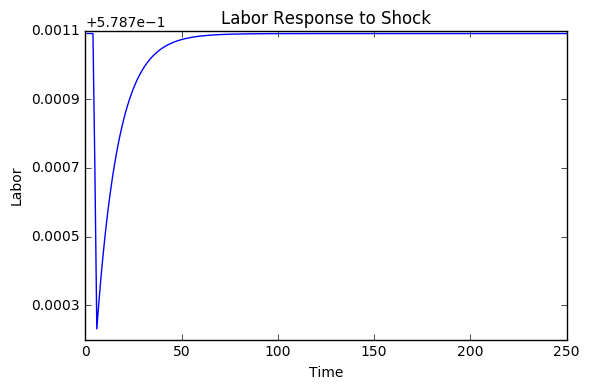

In [173]:
import matplotlib.pyplot as plt

#Create large shock at time t = 5
eps = np.zeros((250))
eps[4] = 3*sigma
z = np.zeros_like(eps)
z[4] = rho*z[3]+eps[4]
  
k = np.zeros((250))
ell = np.zeros((250))
for i in range(1, 250):
    k[i] = P0*k[i-1] + Q0*z[i]
    ell[i] = P1*k[i-1] + Q1*z[i]
    
k = (kbar*np.exp(k))
ell = (ellbar*np.exp(ell))

#Graph the labor simulation in each period
x = np.linspace(1,250,250)
plt.plot(x, ell)
plt.title("Labor Response to Shock")
plt.xlabel("Time")
plt.ylabel("Labor")
plt.tight_layout()
plt.show()

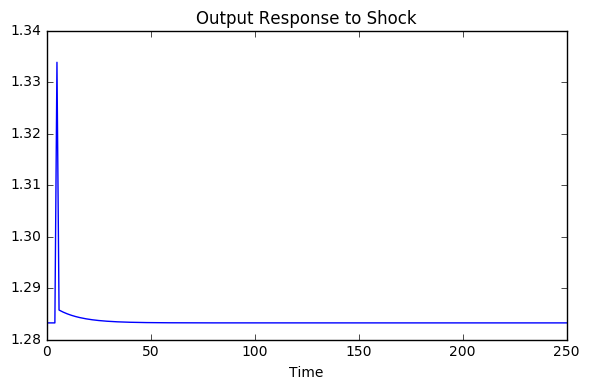

In [174]:
# Impulse response to GDP

y = np.zeros_like(eps)
for i in range(250):
    y[i] = k[i]**alpha*(np.exp(z[i])*ell[i])**(1-alpha)
    
x = np.linspace(1,250,250)
plt.plot(x, y)
plt.title("Output Response to Shock")
plt.xlabel("Time")
plt.ylabel("")
plt.tight_layout()
plt.show()

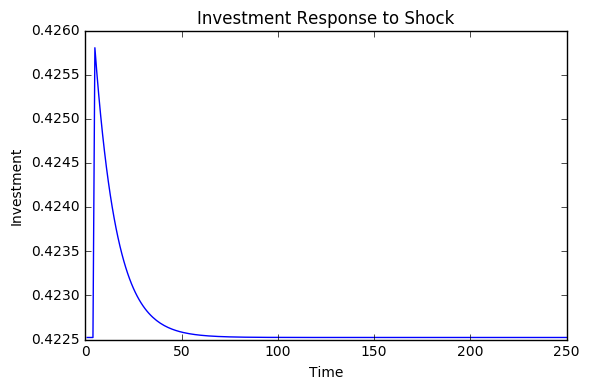

In [175]:
# Impulse response to investment

I = np.zeros_like(eps)
for i in range(250):
    I[i] = delta*k[i]
    
x = np.linspace(1,250,250)
plt.plot(x, I)
plt.title("Investment Response to Shock")
plt.xlabel("Time")
plt.ylabel("Investment")
plt.tight_layout()
plt.show()